Training set - 2022 Jan to 2024 May
Input window = 28

#### 1. Import the libraries

In [2]:
pip install psycopg2-binary

  Using cached psycopg2_binary-2.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
Using cached psycopg2_binary-2.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import psycopg2

# Database connection parameters
db_host = 'maritime-db-server.postgres.database.azure.com'
db_name = 'maritime_db'
db_user = 'maritime_user_kavinda'
db_password = 'mdbuL5jW&xz#8'
db_port = '5432'  # Default PostgreSQL port

# SQL query to get all data for the years 2023 and 2024
query = """
SELECT *
FROM vti_ais
WHERE EXTRACT(YEAR FROM "Received_Timestamp") IN (2022, 2023, 2024)
AND "MMSI" = '249611000';;

"""

# Establish a connection and load data into a DataFrame
try:
    # Connect to the PostgreSQL database
    connection = psycopg2.connect(
        host=db_host,
        database=db_name,
        user=db_user,
        password=db_password,
        port=db_port
    )

    # Load data directly into a pandas DataFrame
    df = pd.read_sql_query(query, connection)

    # Display the first few rows of the DataFrame
    print(df.head())

except Exception as error:
    print(f"Error retrieving data: {error}")

finally:
    if connection:
        connection.close()
        print("PostgreSQL connection closed.")


/tmp/ipykernel_72388/4067295699.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [13]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [15]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

2024-11-13 23:22:19.418432: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 23:22:19.433083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731540139.450551   72388 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731540139.455665   72388 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 23:22:19.473832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [16]:
pip install scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


#### 2. Pre processing the dataset

In [17]:
# load dataset
data = pd.read_csv('data.csv')

In [18]:
data.tail()

,Received_Timestamp,Latitude,Longitude
813153,2024-08-16 20:26:55,6.301900,94.509340
813154,2024-08-16 20:41:52,6.304237,94.558950
813155,2024-08-16 20:44:07,6.304650,94.566895
813156,2024-08-16 20:44:45,6.304758,94.569090
813157,2024-08-16 21:01:24,6.306820,94.625694


In [19]:
# Remove the 'Longitude' column
data = data.drop(columns=['Longitude'])

In [20]:
data.tail()

,Received_Timestamp,Latitude
813153,2024-08-16 20:26:55,6.301900
813154,2024-08-16 20:41:52,6.304237
813155,2024-08-16 20:44:07,6.304650
813156,2024-08-16 20:44:45,6.304758
813157,2024-08-16 21:01:24,6.306820


In [21]:
data['Received_Timestamp'] = pd.to_datetime(data['Received_Timestamp'])  # Convert to datetime
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')       # Convert to numeric, handling errors
#data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')     # Convert to numeric, handling errors
data = data.dropna()  # Drop rows with NaN values if any remain

In [22]:
data.set_index('Received_Timestamp', inplace=True)  # Set datetime as the index

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813158 entries, 2022-01-01 00:11:13 to 2024-08-16 21:01:24
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Latitude  813158 non-null  float64
dtypes: float64(1)
memory usage: 12.4 MB


In [24]:
# Resample data to six-hour bins, handling empty bins with interpolation
data = data.resample('6H').mean()  # Bin by six hours with mean aggregation
data = data.interpolate(method='linear')  # Linear interpolation for missing bins

/tmp/ipykernel_72388/4293368568.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('6H').mean()  # Bin by six hours with mean aggregation


In [25]:
data.head()

,Latitude
Received_Timestamp,
2022-01-01 00:00:00,22.649750
2022-01-01 06:00:00,22.126970
2022-01-01 12:00:00,21.251601
2022-01-01 18:00:00,20.456103
2022-01-02 00:00:00,19.718992


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3836 entries, 2022-01-01 00:00:00 to 2024-08-16 18:00:00
Freq: 6h
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Latitude  3836 non-null   float64
dtypes: float64(1)
memory usage: 59.9 KB


In [27]:
scaler = MinMaxScaler()
# Ensure 'Latitude' is in a 2D format before scaling
data['Latitude'] = scaler.fit_transform(data[['Latitude']])

In [28]:
# Training set: Entire year of 2023 and up to May 2024
training_set = data.loc['2022':'2024-05']

# Testing set: Remaining months in 2024, starting from June 2024
testing_set = data.loc['2024-06':]


In [29]:
training_set.head()

,Latitude
Received_Timestamp,
2022-01-01 00:00:00,0.533879
2022-01-01 06:00:00,0.529038
2022-01-01 12:00:00,0.520932
2022-01-01 18:00:00,0.513565
2022-01-02 00:00:00,0.506739


In [30]:
testing_set.head()

,Latitude
Received_Timestamp,
2024-06-01 00:00:00,0.562647
2024-06-01 06:00:00,0.564772
2024-06-01 12:00:00,0.569488
2024-06-01 18:00:00,0.575726
2024-06-02 00:00:00,0.581195


#### 3. Sliding window approach

In [31]:
# Define the input window size (20 data points)
input_window_size = 28
# Define the output window size (1 data point)
output_window_size = 1
# Define the stride, which determines how much to move forward for each new window (1 data point)
stride = 1

In [32]:
# Apply sliding window to create sequences
# Initialize empty lists to store the input (X) and output (y) sequences
X, y = [], []

# Loop through the dataset to create windows of input and output sequences
for i in range(0, len(training_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window, which is a slice of 20 data points
    input_window = training_set.iloc[i:i+input_window_size][['Latitude']]
    # Define the output window, which is a slice of 1 data point immediately following the input window
    output_window = training_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Latitude']]
    # Append the input window data to X and the last value of output window to y
    X.append(input_window.values)
    y.append(output_window.values[-1])

In [33]:
# Convert X and y lists to numpy arrays for model input
X, y = np.array(X), np.array(y)

# Print the number of samples created
print(f"Number of samples: {X.shape[0]}")
# Print the shape of the input (X) and output (y) arrays
print(f"Input shape: {X.shape}, Target shape: {y.shape}")

Number of samples: 3500
Input shape: (3500, 28, 1), Target shape: (3500, 1)


#### 4. Define LSTM model architecture

In [34]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define a function to create an LSTM model with specified hyperparameters
def build_model(units=50, lstm_layers=2, dropout_rate=0.2, recurrent_dropout=0.2, activation='tanh', learning_rate=0.001):
    """
    Builds an LSTM model with the given parameters.

    Parameters:
        units (int): Number of units in each LSTM layer.
        lstm_layers (int): Number of stacked LSTM layers.
        dropout_rate (float): Dropout rate for regularization.
        recurrent_dropout (float): Dropout rate for the recurrent connections.
        activation (str): Activation function for LSTM layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): Compiled Keras model ready for training.
    """
    # Initialize a Sequential model
    model = Sequential()
    
    # Add LSTM layers
    for i in range(lstm_layers - 1):
        # Add intermediate LSTM layers with return_sequences=True for stacking
        model.add(LSTM(units=units, activation=activation, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add the final LSTM layer without return_sequences, as this is a many-to-one model
    model.add(LSTM(units=units, activation=activation, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add a Dense layer with 1 unit for output (for regression)
    model.add(Dense(1))
    
    # Initialize the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model using mean squared error (MSE) as the loss function, which is suitable for regression
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

# Initialize variables to keep track of the best model and lowest validation loss
best_model = None
best_loss = float('inf')  # Start with a high initial loss for comparison

# Define hyperparameter grids for tuning
units_list = [50, 100, 150]       # Different numbers of units to try in LSTM layers
layers_list = [1, 2, 3]           # Different numbers of LSTM layers to try
dropout_list = [0.2, 0.3, 0.5]    # Different dropout rates to test for regularization
learning_rates = [0.0001, 0.001, 0.005]  # Different learning rates for the optimizer
batch_sizes = [16, 32, 48]        # Different batch sizes for training

# Perform grid search across all combinations of hyperparameters
for units in units_list:
    for layers in layers_list:
        for dropout in dropout_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Print the current combination of hyperparameters being tested
                    print(f"Training model with units={units}, layers={layers}, dropout={dropout}, lr={lr}, batch_size={batch_size}")
                    
                    # Build a model with the current set of hyperparameters
                    model = build_model(units=units, lstm_layers=layers, dropout_rate=dropout, learning_rate=lr)
                    
                    # Define early stopping to stop training if validation loss doesn't improve for a number of epochs
                    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    
                    # Define learning rate scheduler to reduce learning rate if validation loss plateaus
                    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
                    
                    # Train the model on the data with a validation split of 30%
                    # Early stopping and learning rate scheduler will be used as callbacks
                    history = model.fit(X, y, 
                                        epochs=100, 
                                        batch_size=batch_size, 
                                        validation_split=0.3, 
                                        callbacks=[early_stopping, lr_scheduler], 
                                        verbose=1)
                    
                    # Retrieve the minimum validation loss achieved during training
                    val_loss = min(history.history['val_loss'])
                    
                    # Check if the current model has achieved a lower validation loss than the best so far
                    if val_loss < best_loss:
                        # Update the best model and best loss
                        best_loss = val_loss
                        best_model = model
                        best_params = (units, layers, dropout, lr, batch_size)
                        best_history = history

# At the end of the search, 'best_model' contains the model with the lowest validation loss
# 'best_params' holds the parameters that yielded the best model, and 'best_history' contains the training history


Training model with units=50, layers=1, dropout=0.2, lr=0.0001, batch_size=16
Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1813 - val_loss: 0.0109 - learning_rate: 1.0000e-04
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0328 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0234 - val_loss: 0.0139 - learning_rate: 1.0000e-04
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0230 - learning_rate: 1.0000e-04
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0243 - learning_rate: 1.0000e-04
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 0.0246 - learning_rate: 5.0000e-05
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0248 - learning_rate: 5.0000e-05
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step -

2024-11-13 23:22:27.146736: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


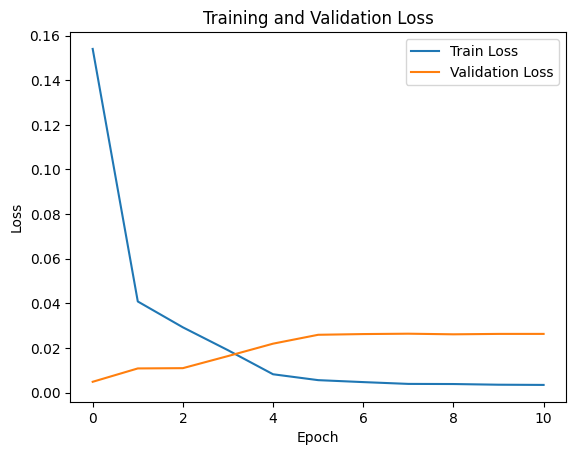

In [35]:
# Plot the training history of the best model
# Plot the loss and validation loss over epochs for the best model
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Output the best model parameters
# Print the best hyperparameters found in the grid search
print(f"Best model parameters: Units={best_params[0]}, Layers={best_params[1]}, Dropout={best_params[2]}, Learning Rate={best_params[3]}, Batch Size={best_params[4]}")

Best model parameters: Units=150, Layers=1, Dropout=0.2, Learning Rate=0.0001, Batch Size=48


In [37]:
#best_model.save('LL Prediction 1.h5')

### Testing Part

#### 1) Load the model

In [38]:
best_model

<Sequential name=sequential_164, built=True>

#### 2) Window sampling for testing set

In [39]:
import numpy as np

# Parameters for window sampling
input_window_size = 28
output_window_size = 1
stride = 1

# Initialize lists to store the input (X_test) and output (y_test) sequences for testing set
X_test, y_test = [], []

# Loop through the testing set to create windows of input and output sequences
for i in range(0, len(testing_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window (20 data points)
    input_window = testing_set.iloc[i:i+input_window_size][['Latitude']]
    # Define the output window (1 data point immediately following the input window)
    output_window = testing_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Latitude']]
    # Append the input window to X_test and the last value of output window to y_test
    X_test.append(input_window.values)
    y_test.append(output_window.values[-1])

# Convert X_test and y_test lists to numpy arrays for model input
X_test, y_test = np.array(X_test), np.array(y_test)

# Print the number of samples created for testing
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Test input shape: {X_test.shape}, Test target shape: {y_test.shape}")

Number of test samples: 280
Test input shape: (280, 28, 1), Test target shape: (280, 1)


#### 3) Test the Testing Set Using the Imported Model

In [40]:
best_model

<Sequential name=sequential_164, built=True>

In [41]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


#### 4) Calculate Error on the Testing Set

In [42]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between predicted and actual values
error = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Set: {error}")

Mean Squared Error on the Testing Set: 0.008484519757886888


In [43]:
# Get the original data for predicted cells and add it to testing set as a new column
# Convert predictions to a DataFrame for easier concatenation
predictions_df = pd.DataFrame(y_pred, columns=['Predicted_Latitude'])

In [44]:
predictions_df.head()

,Predicted_Latitude
0,0.550586
1,0.549675
2,0.548427
3,0.546995
4,0.545473


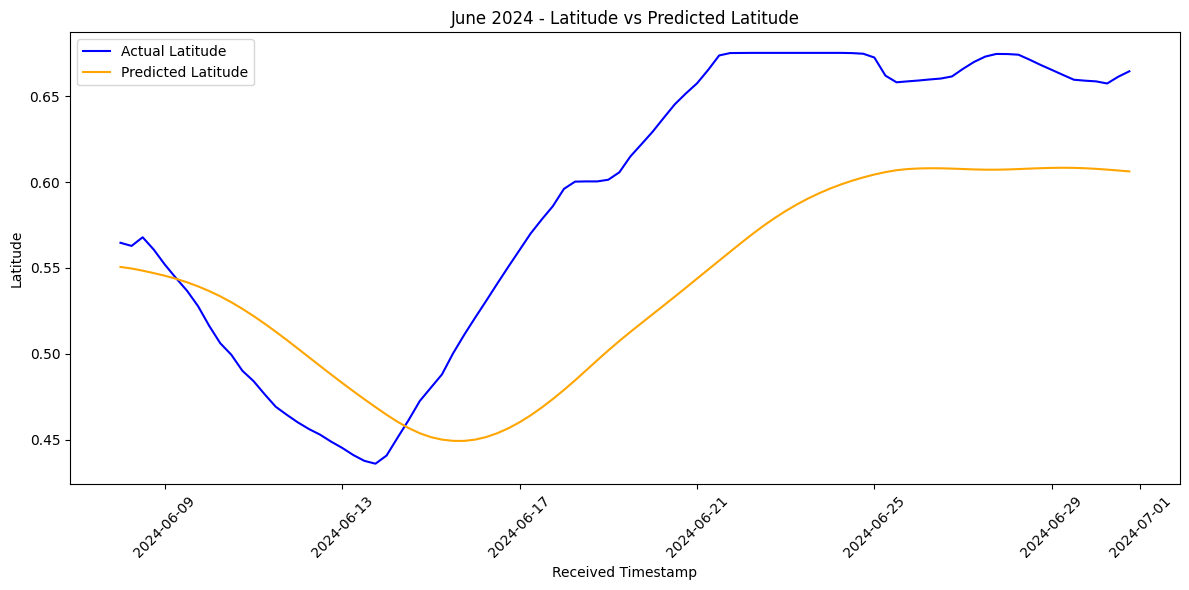

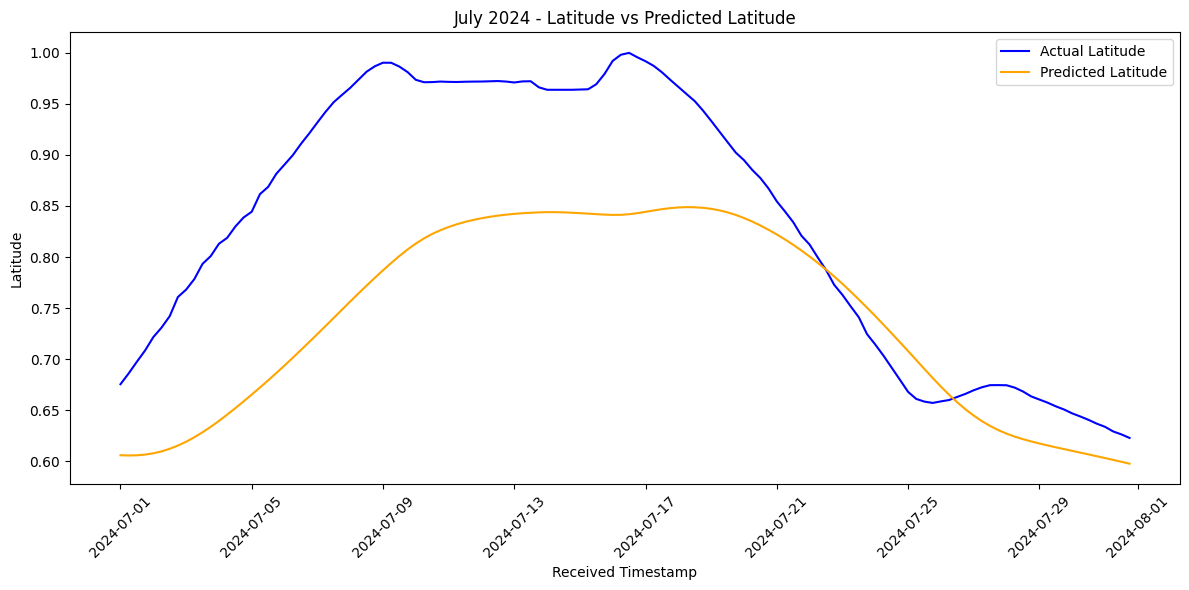

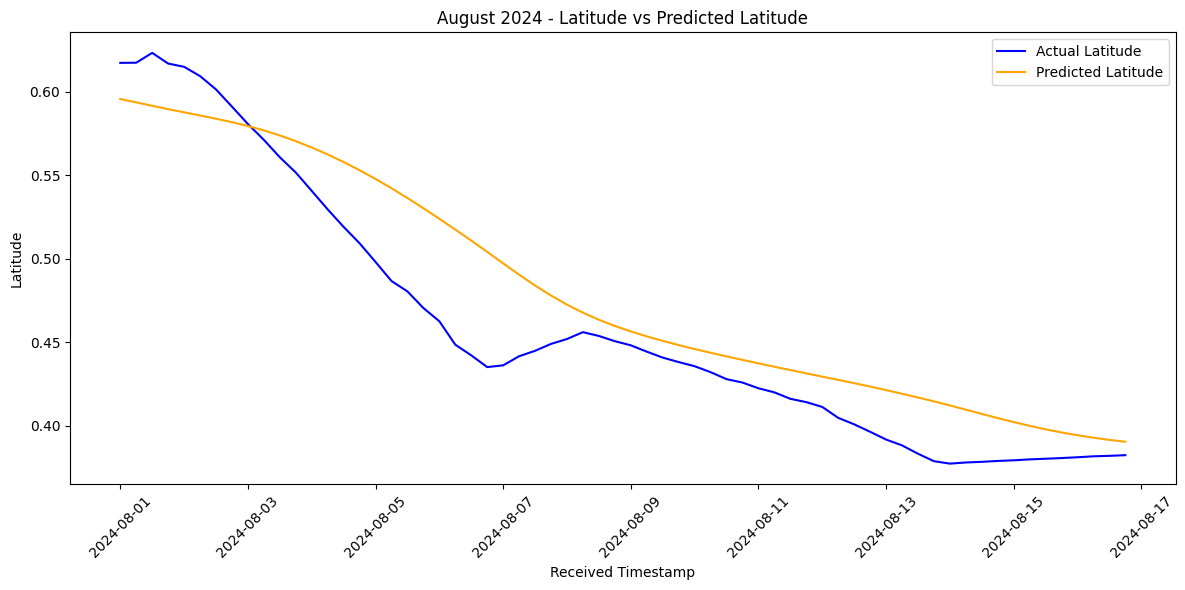

In [45]:
# Convert the predictions (y_pred) into a DataFrame for easy handling with timestamps
# We assume `testing_set.index[input_window_size:]` matches the `y_pred` in length
predicted_latitudes = pd.DataFrame(y_pred, index=testing_set.index[input_window_size:], columns=['Predicted_Latitude'])

# Add the 'Latitude' column from `testing_set` as the true values for comparison
testing_latitudes = testing_set[['Latitude']].iloc[input_window_size:]  # Skip initial window

# Define the months for filtering and specific timestamps for illustration
months = {
    'June': '2024-06',
    'July': '2024-07',
    'August': '2024-08'
}

# Plot each month's data
for month_name, month_str in months.items():
    # Filter data for the entire month
    monthly_actual_data = testing_latitudes[testing_latitudes.index.to_period('M') == month_str]
    monthly_predicted_data = predicted_latitudes[predicted_latitudes.index.to_period('M') == month_str]
    
    # Plot actual vs predicted latitude values for the month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_actual_data.index, monthly_actual_data['Latitude'], label='Actual Latitude', color='blue')
    plt.plot(monthly_predicted_data.index, monthly_predicted_data['Predicted_Latitude'], label='Predicted Latitude', color='orange')
    
    # Formatting the plot
    plt.title(f'{month_name} 2024 - Latitude vs Predicted Latitude')
    plt.xlabel('Received Timestamp')
    plt.ylabel('Latitude')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [46]:
y_test_real = scaler.inverse_transform(y_test)
#y_test = y_test.reshape(-1, 1)  # Reshape if necessary
#y_pred = y_pred.reshape(-1, 1)  # Reshape if necessary

In [47]:
y_test_real

array([[25.97180744],
       [25.77515932],
       [26.31819316],
       [25.54576214],
       [24.60296175],
       [23.76164734],
       [22.96193654],
       [21.98669953],
       [20.75568528],
       [19.65923326],
       [18.933386  ],
       [17.92575052],
       [17.28073893],
       [16.45450674],
       [15.66919939],
       [15.16199359],
       [14.68255261],
       [14.26538734],
       [13.91375453],
       [13.4736939 ],
       [13.0794517 ],
       [12.63182437],
       [12.26528943],
       [12.08589759],
       [12.59870332],
       [13.72820221],
       [14.84033727],
       [16.02938198],
       [16.86632795],
       [17.69944362],
       [19.02252439],
       [20.18296209],
       [21.27411182],
       [22.33634928],
       [23.41942198],
       [24.48111009],
       [25.51978358],
       [26.55880673],
       [27.44007351],
       [28.27288094],
       [29.35977371],
       [29.81559335],
       [29.8305722 ],
       [29.82925217],
       [29.93503546],
       [30

In [48]:
y_pred_real = scaler.inverse_transform(y_pred)
y_pred_real

array([[24.453856 ],
       [24.35554  ],
       [24.220718 ],
       [24.066063 ],
       [23.901772 ],
       [23.713072 ],
       [23.490324 ],
       [23.232664 ],
       [22.940247 ],
       [22.609222 ],
       [22.234457 ],
       [21.81956  ],
       [21.370535 ],
       [20.89059  ],
       [20.38732  ],
       [19.863169 ],
       [19.324028 ],
       [18.778511 ],
       [18.23301  ],
       [17.693354 ],
       [17.163439 ],
       [16.644678 ],
       [16.138187 ],
       [15.644307 ],
       [15.166853 ],
       [14.718489 ],
       [14.322923 ],
       [13.998948 ],
       [13.756755 ],
       [13.600412 ],
       [13.52236  ],
       [13.518623 ],
       [13.600615 ],
       [13.765177 ],
       [14.005864 ],
       [14.316464 ],
       [14.692222 ],
       [15.128307 ],
       [15.617723 ],
       [16.151426 ],
       [16.722483 ],
       [17.323969 ],
       [17.950882 ],
       [18.584267 ],
       [19.204527 ],
       [19.801334 ],
       [20.37291  ],
       [20.92